In [1]:
# Load dependent libraries
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import sys

import sampling as sampling
from sampling import ReverseDiffusionPredictor,LangevinCorrector,AnnealedLangevinDynamics ,EulerMaruyamaPredictor,AncestralSamplingPredictor
import aapm_sin_ncsnpp_3h as configs_3h  
import aapm_sin_ncsnpp_wavelet as configs_A 

sys.path.append('..')
from losses import get_optimizer
from models.ema import ExponentialMovingAverage

import numpy as np

from utils import restore_checkpoint

import models
from models import utils as mutils
from models import ncsnv2
from models import ncsnpp
from models import ddpm as ddpm_model
from models import layerspp
from models import layers
from models import normalization
from sde_lib import VESDE, VPSDE, subVPSDE


In [14]:
# Set the model parameters and load the network
check_num = [23,24]
ckpt_filename_3h = './exp_3h/checkpoints/checkpoint_{}.pth'.format(check_num[0])
ckpt_filename_A = './exp_wavelet/checkpoints/checkpoint_{}.pth'.format(check_num[1])
assert os.path.exists(ckpt_filename_3h)
assert os.path.exists(ckpt_filename_A)
config_3h = configs_3h.get_config()
config_A = configs_A.get_config()
sde_3h = VESDE(sigma_min=config_3h.model.sigma_min, sigma_max=config_3h.model.sigma_max, N=config_3h.model.num_scales)
sde_A = VESDE(sigma_min=config_A.model.sigma_min, sigma_max=config_A.model.sigma_max, N=config_A.model.num_scales)
sampling_eps = 1e-5

# 3h model
batch_size = 1 
config_3h.training.batch_size = batch_size
config_3h.eval.batch_size = batch_size

random_seed = 0 

sigmas = mutils.get_sigmas(config_3h)
h3_model = mutils.create_model(config_3h)

optimizer = get_optimizer(config_3h, h3_model.parameters())
ema = ExponentialMovingAverage(h3_model.parameters(),
                            decay=config_3h.model.ema_rate)
state = dict(step=0, optimizer=optimizer,
          model=h3_model, ema=ema)

state = restore_checkpoint(ckpt_filename_3h, state, config_3h.device)
ema.copy_to(h3_model.parameters())
        
# wavelet model
batch_size = 1 
config_A.training.batch_size = batch_size
config_A.eval.batch_size = batch_size

random_seed = 0 

sigmas = mutils.get_sigmas(config_A)
A_model = mutils.create_model(config_A)

optimizer = get_optimizer(config_A, A_model.parameters())
ema = ExponentialMovingAverage(A_model.parameters(),
                            decay=config_A.model.ema_rate)
state = dict(step=0, optimizer=optimizer,
          model=A_model, ema=ema)

state = restore_checkpoint(ckpt_filename_A, state, config_A.device)
ema.copy_to(A_model.parameters())

predictor = get_predict(predict) 
corrector = get_correct(correct) 

snr = 0.16
n_steps = 1
probability_flow = False 

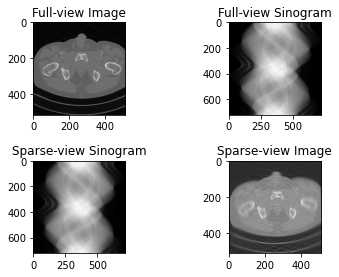

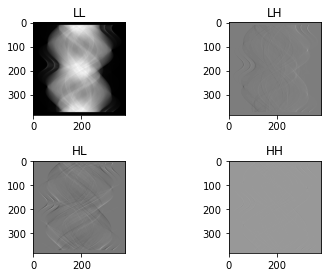

Step: 0   Views:60  PSNR:[ 21.773]  MSE:[ 6.648]
Step: 1   Views:60  PSNR:[ 19.906]  MSE:[ 10.219]
Step: 2   Views:60  PSNR:[ 19.917]  MSE:[ 10.193]
Step: 3   Views:60  PSNR:[ 19.38]  MSE:[ 11.534]
Step: 4   Views:60  PSNR:[ 19.568]  MSE:[ 11.045]
Step: 5   Views:60  PSNR:[ 19.404]  MSE:[ 11.471]
Step: 6   Views:60  PSNR:[ 19.464]  MSE:[ 11.314]
Step: 7   Views:60  PSNR:[ 19.656]  MSE:[ 10.824]
Step: 8   Views:60  PSNR:[ 19.597]  MSE:[ 10.974]
Step: 9   Views:60  PSNR:[ 19.912]  MSE:[ 10.206]
Step: 10   Views:60  PSNR:[ 19.828]  MSE:[ 10.405]
Step: 11   Views:60  PSNR:[ 20.143]  MSE:[ 9.677]
Step: 12   Views:60  PSNR:[ 20.01]  MSE:[ 9.977]
Step: 13   Views:60  PSNR:[ 20.313]  MSE:[ 9.305]
Step: 14   Views:60  PSNR:[ 20.13]  MSE:[ 9.706]
Step: 15   Views:60  PSNR:[ 20.421]  MSE:[ 9.075]
Step: 16   Views:60  PSNR:[ 20.206]  MSE:[ 9.537]
Step: 17   Views:60  PSNR:[ 20.482]  MSE:[ 8.95]
Step: 18   Views:60  PSNR:[ 20.237]  MSE:[ 9.468]
Step: 19   Views:60  PSNR:[ 20.482]  MSE:[ 8.95]
Step:

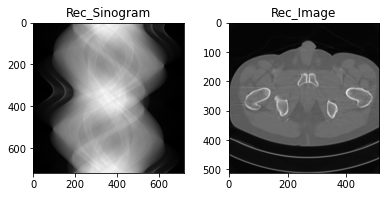

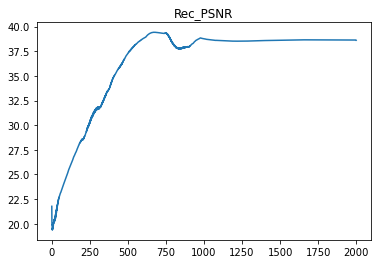

MAX:  PSNR:[ 39.421] MSE:[ 0.114]


In [58]:
# Image reconstruction is under way
import sampling
sampling_fn = sampling.get_pc_sampler(sde_3h, sde_A, predictor, corrector,
                                    None, snr, n_steps=n_steps,
                                    probability_flow=probability_flow,
                                    continuous_3h=config_3h.training.continuous,
                                    continuous_A=config_A.training.continuous,
                                    eps=sampling_eps, device_3h=config_3h.device, device_A=config_A.device)

sampling_fn(h3_model,A_model,check_num,predict,correct)